In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf
import yahoofinancials
import seaborn as sns
import datetime
from datetime import date
import matplotlib.pyplot as plt

import math
from datetime import date

In [2]:
N = norm.cdf

In [3]:
import os
from pathlib import Path

import sys
import csv

# -----------------------------------------------------------------------------

root = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(''))))
sys.path.append(root + '/python')

import ccxt


# -----------------------------------------------------------------------------

def retry_fetch_ohlcv(exchange, max_retries, symbol, timeframe, since, limit):
    num_retries = 0
    try:
        num_retries += 1
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
        # print('Fetched', len(ohlcv), symbol, 'candles from', exchange.iso8601 (ohlcv[0][0]), 'to', exchange.iso8601 (ohlcv[-1][0]))
        return ohlcv
    except Exception:
        if num_retries > max_retries:
            raise  # Exception('Failed to fetch', timeframe, symbol, 'OHLCV in', max_retries, 'attempts')


def scrape_ohlcv(exchange, max_retries, symbol, timeframe, since, limit):
    earliest_timestamp = exchange.milliseconds()
    timeframe_duration_in_seconds = exchange.parse_timeframe(timeframe)
    timeframe_duration_in_ms = timeframe_duration_in_seconds * 1000
    timedelta = limit * timeframe_duration_in_ms
    all_ohlcv = []
    while True:
        fetch_since = earliest_timestamp - timedelta
        ohlcv = retry_fetch_ohlcv(exchange, max_retries, symbol, timeframe, fetch_since, limit)
        # if we have reached the beginning of history
        if ohlcv[0][0] >= earliest_timestamp:
            break
        earliest_timestamp = ohlcv[0][0]
        all_ohlcv = ohlcv + all_ohlcv
        print(len(all_ohlcv), symbol, 'candles in total from', exchange.iso8601(all_ohlcv[0][0]), 'to', exchange.iso8601(all_ohlcv[-1][0]))
        # if we have reached the checkpoint
        if fetch_since < since:
            break
    return all_ohlcv


def write_to_csv(filename, exchange, data):
    p = Path("", str(exchange))
    p.mkdir(parents=True, exist_ok=True)
    full_path = p / str(filename)
    with Path(full_path).open('w+', newline='') as output_file:
        csv_writer = csv.writer(output_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerows(data)


def scrape_candles_to_csv(filename, exchange_id, max_retries, symbol, timeframe, since, limit):
    # instantiate the exchange by id
    exchange = getattr(ccxt, exchange_id)({
        'enableRateLimit': True,  # required by the Manual
    })
    # convert since from string to milliseconds integer if needed
    if isinstance(since, str):
        since = exchange.parse8601(since)
    # preload all markets from the exchange
    exchange.load_markets()
    # fetch all candles
    ohlcv = scrape_ohlcv(exchange, max_retries, symbol, timeframe, since, limit)
    # save them to csv file
    write_to_csv(filename, exchange, ohlcv)
    print('Saved', len(ohlcv), 'candles from', exchange.iso8601(ohlcv[0][0]), 'to', exchange.iso8601(ohlcv[-1][0]), 'to', filename)

In [4]:
scrape_candles_to_csv('eth_usdt_1h.csv', 'binance', 3, 'ETH/USDT', '1h', '2021-01-0100:00:00Z', 1000)

1000 ETH/USDT candles in total from 2022-08-23T06:00:00.000Z to 2022-10-03T21:00:00.000Z
2000 ETH/USDT candles in total from 2022-07-12T14:00:00.000Z to 2022-10-03T21:00:00.000Z
3000 ETH/USDT candles in total from 2022-05-31T22:00:00.000Z to 2022-10-03T21:00:00.000Z
4000 ETH/USDT candles in total from 2022-04-20T06:00:00.000Z to 2022-10-03T21:00:00.000Z
5000 ETH/USDT candles in total from 2022-03-09T14:00:00.000Z to 2022-10-03T21:00:00.000Z
6000 ETH/USDT candles in total from 2022-01-26T22:00:00.000Z to 2022-10-03T21:00:00.000Z
7000 ETH/USDT candles in total from 2021-12-16T06:00:00.000Z to 2022-10-03T21:00:00.000Z
8000 ETH/USDT candles in total from 2021-11-04T14:00:00.000Z to 2022-10-03T21:00:00.000Z
9000 ETH/USDT candles in total from 2021-09-23T22:00:00.000Z to 2022-10-03T21:00:00.000Z
10000 ETH/USDT candles in total from 2021-08-13T06:00:00.000Z to 2022-10-03T21:00:00.000Z
11000 ETH/USDT candles in total from 2021-07-02T14:00:00.000Z to 2022-10-03T21:00:00.000Z
12000 ETH/USDT cand

In [62]:
df = pd.read_csv('Binance/eth_usdt_1h.csv')

In [63]:
df.columns = ['unix', 'Open', 'High', 'Low', 'Close', 'Volume']
df = df.set_index('unix')

<AxesSubplot:xlabel='unix'>

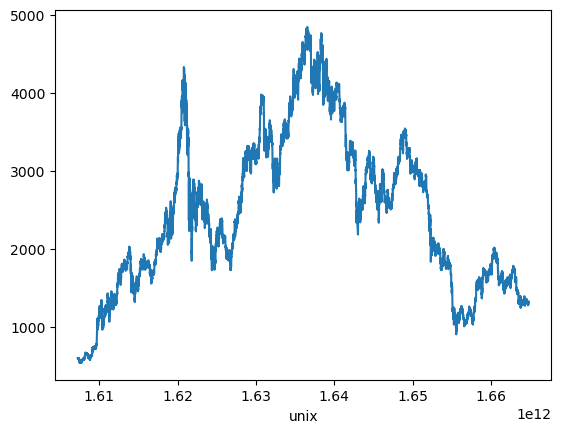

In [64]:
df["Close"].plot()

In [65]:
df['Date'] = pd.to_datetime(df.index,unit='ms')
df = df.set_index('Date')

In [66]:
length = len(df)
length = int(length / 2)

df = df.drop(df.index[length])

In [67]:
"""today = str(date.today())
print(today)"""

'today = str(date.today())\nprint(today)'

In [68]:
# yf.pdr_override() 
# df = pdr.get_data_yahoo("ETH-USD", start="2022-01-01", end=today)

# df['Date'] = df.index
df['Return'] = 100 * (df['Close'].pct_change())

daily_volatility = df['Return'].std()
monthly_volatility = math.sqrt(30) * daily_volatility

period_volatility = (math.sqrt(len(df.index)) * daily_volatility) / 100

print("volatility over period:", period_volatility)

volatility over period: 1.3672550444754419


In [69]:
df["Date"] = df.index

In [70]:
df

,Open,High,Low,Close,Volume,Return,Date
Date,,,,,,,
2020-12-06 07:00:00,597.42,604.09,596.18,600.54,24939.57494,NaN,2020-12-06 07:00:00
2020-12-06 08:00:00,600.56,601.74,590.07,591.30,39081.33079,-1.538615,2020-12-06 08:00:00
2020-12-06 09:00:00,591.31,593.62,586.00,590.97,38586.85312,-0.055809,2020-12-06 09:00:00
2020-12-06 10:00:00,590.97,592.30,588.28,590.68,17879.15321,-0.049072,2020-12-06 10:00:00
2020-12-06 11:00:00,590.61,593.72,588.77,593.26,15464.03746,0.436785,2020-12-06 11:00:00
...,...,...,...,...,...,...,...
2022-10-03 17:00:00,1320.46,1329.20,1320.36,1325.84,23594.21520,0.407434,2022-10-03 17:00:00
2022-10-03 18:00:00,1325.83,1329.90,1316.20,1317.60,19449.12620,-0.621493,2022-10-03 18:00:00
2022-10-03 19:00:00,1317.59,1321.54,1309.38,1317.90,24317.60910,0.022769,2022-10-03 19:00:00


In [71]:
def delta_BS_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1) - 1

def delta_BS_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1)

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
#     print(d1, d2)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T)* N(-d2) - S * N(-d1)

In [72]:
last_prices = df[["Close"]].to_numpy()

In [73]:
len(last_prices)

15997

In [74]:
len(last_prices) / 24 / 365

1.8261415525114155

In [75]:
1 *365 * 24

8760

In [76]:
last_prices1 = []

for i in range(8760):
    last_prices1.append(last_prices[i])
    
    
last_prices = []
last_prices = last_prices1

In [77]:
x = []

for i in range(len(last_prices)):
    x.append(i)

In [78]:
option = {"T": 1, "K": 1000, "r": 0, "sigma": 0.7}

In [79]:
S0 = option['K']
K = option['K']
T = option['T']
r = option['r']
sigma = option['sigma']


asset = 0
initial_usdc = 2000
usdc = initial_usdc
prev_asset = 0

In [80]:
call_replicated_payoff = []
call_true_payoff = []

deltas = []

    
for i in range(len(last_prices)):
    t = (T / 24) # * i
    prev_asset = asset
    asset = delta_BS_call(last_prices[i], K, T - t, r, sigma)
    usdc = usdc - (asset - prev_asset) * last_prices[i]
    deltas.append(asset)
    
    call_replicated_payoff.append(asset*last_prices[i] + usdc - initial_usdc)
    call_true_payoff.append(max(0, last_prices[i] - K) - BS_CALL(S0, K, T, r, sigma))

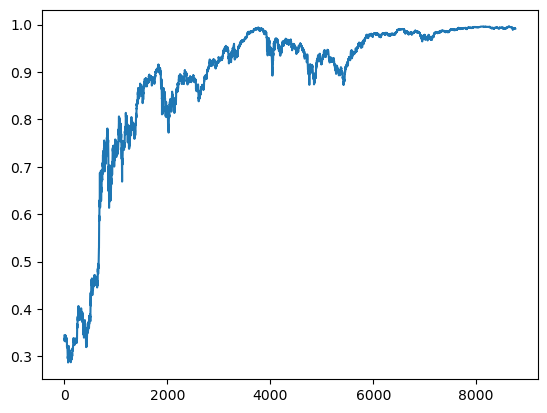

In [81]:
plt.plot(x, deltas)

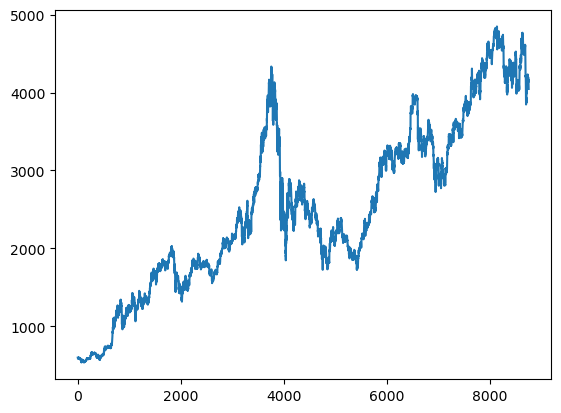

In [82]:
plt.plot(x ,last_prices)

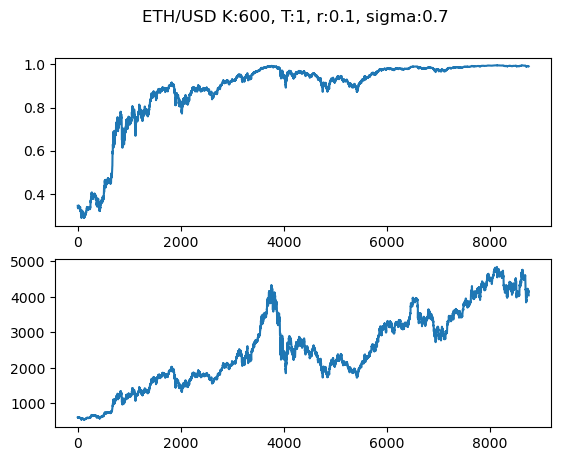

In [83]:
fig, ax = plt.subplots(2)
fig.suptitle('ETH/USD K:600, T:1, r:0.1, sigma:0.7')
ax[0].plot(x, deltas)
ax[1].plot(x, last_prices)

In [84]:
arr = []

coordinates_lists = []

usdc = initial_usdc

for i in range(len(deltas)):
    
    delta = deltas[i].tolist()
    delta = delta[0]
  
    arr.append(delta)
    
    last_price = last_prices[i].tolist()
    last_price = last_price[0]
    
    usdc = (usdc - (asset - prev_asset) * last_price).tolist()
    usdc = usdc[0]
    
    arr.append(usdc)
    
    coordinates_lists.append(arr)
    
    arr = []

In [85]:
coordinates_lists

[[0.3440250164893263, 2000.1326767842397],
 [0.3357354259825904, 2000.263312183249],
 [0.33543843443587706, 2000.3938746756426],
 [0.3351773898460845, 2000.5243730985865],
 [0.3374980692756602, 2000.6554415187052],
 [0.3331143403382619, 2000.785434013924],
 [0.3323297784931491, 2000.9152343007934],
 [0.33871082302578404, 2001.0466009752477],
 [0.3389532443136278, 2001.178027300569],
 [0.33844141530592287, 2001.309327696282],
 [0.3394289822162142, 2001.4408711140463],
 [0.338746740022259, 2001.5722466256661],
 [0.33959051548530766, 2001.7038298106752],
 [0.3390609732016927, 2001.8352826474932],
 [0.3425216441118746, 2001.9675882707818],
 [0.33719246568550676, 2002.0985815749937],
 [0.3449190558230647, 2002.2314792883708],
 [0.34162596076202423, 2002.363563982522],
 [0.338674905079848, 2002.4949218198108],
 [0.3373183106791021, 2002.6259460541019],
 [0.3387198023639248, 2002.7573149378475],
 [0.3400749990776927, 2002.8890174245907],
 [0.34015572936463057, 2003.0207397949564],
 [0.3419395

Text(0, 0.5, 'USD')

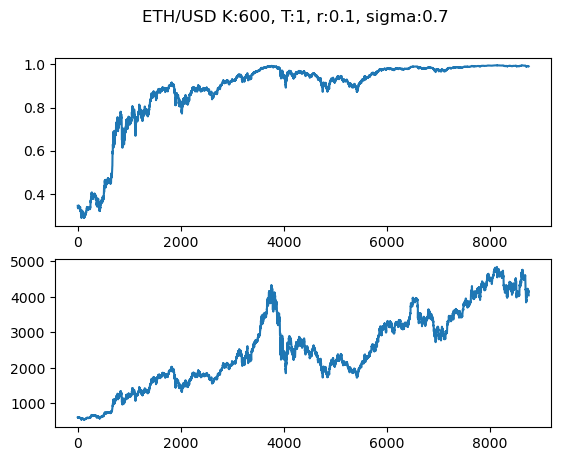

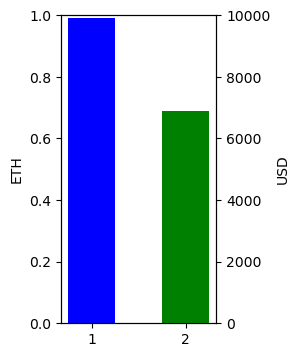

In [86]:
fig, ax = plt.subplots(2)
fig.suptitle('ETH/USD K:600, T:1, r:0.1, sigma:0.7')
ax[0].plot(x, deltas)
ax[1].plot(x, last_prices)

data = coordinates_lists[len(coordinates_lists) - 1]

X = np.arange(1)
fig = plt.figure(figsize=(2, 4))

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

ax.set_ylim(0, 1)
ax2.set_ylim(0, 10000)

width = 1

ax.bar(X + 1, data[0], color = 'b', width = 0.5)
ax2.bar(X + 2, data[1], color = 'g', width = 0.5)

ax.set_ylabel('ETH')
ax2.set_ylabel('USD')

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [ ]:
for i in range(len(coordinates_lists)):
    
    data = coordinates_lists[i]

    X = np.arange(1)
    fig = plt.figure()

    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

    ax.set_ylim(0, 1)
    ax2.set_ylim(0, 600)

    width = 0.4

    ax.bar(X + 1, data[0], color = 'b', width = 1)
    ax2.bar(X + 2, data[1], color = 'g', width = 1)

    ax.set_ylabel('ETH')
    ax2.set_ylabel('USD')
    
    fig.savefig('figs/test{}.jpg'.format(i),
        format='jpeg',
        dpi=100,
        bbox_inches='tight')

In [ ]:
# frames between transitions
n_frames = 2
x = [1, 2]
coordinates_lists = [[0, 0],
                     [10, 30],
                     [70, 40],
                     [10, 20],
                     [50, 40],
                     [75, 0],
                     [0, 0]]
                     
print('Creating charts\n')
filenames = []
for index in np.arange(0, len(coordinates_lists)-1):
    # get current and next y coordinates
    y = coordinates_lists[index]
    y1 = coordinates_lists[index+1]
    
    # calculate the distance to the next position
    y_path = np.array(y1) - np.array(y)
    for i in np.arange(0, n_frames + 1):
        # divide the distance by the number of frames 
        # and multiply it by the current frame number
        y_temp = (y + (y_path / n_frames) * i)
        # plot
        plt.bar(x, y_temp)
        plt.ylim(0,80)
        # build file name and append to list of file names
        filename = f'frame_{index}_{i}.png'
        filenames.append(filename)
        # last frame of each viz stays longer
        if (i == n_frames):
            for i in range(5):
                filenames.append(filename)
        # save img
        plt.savefig(filename)
        plt.close()
print('Charts saved\n')
# Build GIF
print('Creating gif\n')
with imageio.get_writer('mybars.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('Gif saved\n')
print('Removing Images\n')
# Remove files
for filename in set(filenames):
    os.remove(filename)
print('DONE')

In [ ]:
# not finished...

In [ ]:
# expiration
T = len(df) / 365 / 24
T

In [ ]:
def min_amount(S,K,T,r,sigma,amount):
    C = BS_CALL(S, K, T, r, sigma)

    minimum = C * amount
    
    minimum = round(minimum,3)
    
    return minimum

In [ ]:
S = df["Close"].iloc[:1]
K = 2500
T = len(df) / 365 / 24
r = 0.1
sigma = 0.9

amount = 1

In [ ]:
# minimum amount of cash to replicate option
min_amount(S,K,T,r,sigma,amount)

In [ ]:
df["Date"] = df.index
df.drop(columns=['Date'])

In [ ]:
# Time to expiration in years
df['T'] = df.apply(lambda x: expiration(x['Date'], T), axis=1)

In [ ]:
# Delta
df['Delta'] = df.apply(lambda x: delta_BS_CALL(x['Close'], K, x['T'], r, sigma), axis=1)

In [ ]:
df["Delta"].plot()

In [ ]:
df["Close"].plot()

In [ ]:
df.head(10)

In [ ]:
# calculate the change in delta
df["dDelta"] = df["Delta"].diff();

In [ ]:
# calcuate the change in cash balance 
df["dCash"] = df["dDelta"] * df["Close"] *-1

In [ ]:
df["dCash"].plot()

In [ ]:
# initial price
S = df["Close"].iloc[:3]
cash = df["Close"].iloc[:3] - (df["Delta"].iloc[:3] * S)

cash

In [ ]:

# Calculate the amount of cash held
df["Cash"] = 5000 + df["dCash"]

In [ ]:
df["Cash"].plot()

In [ ]:
# calculate portfolio value 
df["Value"] = df["Cash"] + df["Delta"] * df["Close"]

In [ ]:
df["Value"].plot()

In [ ]:
df

In [ ]:
plt.plot(df["Close"], df["Value"], 'ro', )


In [ ]:
plt.plot(df["Close"], df["Value"], 'ro', )

In [ ]:
def cash(S, dDelta):
    
    cash = df["cash"].shift(1) - (S * dDelta)

    # cash = df["cash"].shift(1) + (S * dDelta * -1)
    
    return cash

In [ ]:
df['cash'] = df.apply(lambda x: cash(df["Close"], df["dDelta"]), axis=1)

In [ ]:
# not finished...

def cashBalance(S, delta0, delta1, cash):
    cash1 = cash - ((delta1 - delta0) * S)    
    return cash1

def underlyingBalance(delta, liquidity):
    return 0
    


In [ ]:
def portfolioValue():
    return 0